# Explore bias towards entropy induced by activation function

After observing the activations in the hidden layers over the course of training, we want to get a better feeling for the effect that the activation function has on the mutual information of these layers with the input. As the feed-forward mapping of the network is deterministic (up to numerical precision), the mutual information of the hidden layer with the input boils down to the entropy of the activation in the hidden layer. 

In the following we will create an artificial sample of data and manipulate it by applying different activation functions. We will compare the entropy of the output with the entropy of the original distribution. Furthermore, we will quantify the effect that different activation functions have on the entropy of the representation, which we call the inherent bias towards the entropy for that activation function.



In [1]:
import numpy as np
np.random.seed(0)
from scipy import stats
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

We uniformly draw 4096 samples from the interval $[-1, 1]$. Below we see the distribution of these values in a histogram with 50 bins. In this simulation the histogram counts serve as the "activation pattern" that could appear in a hidden layer of a neural network for uniformly distributed activations. Moreover we calculate the entropy of this hypothetical activation pattern.

Entropy of the uniform distribution: 5.634427827586692


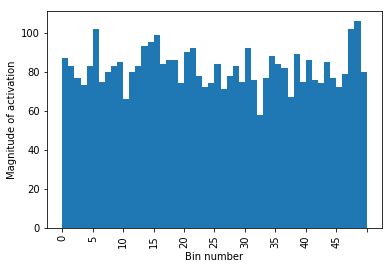

In [2]:
number_of_samples = 4096
uniform = np.random.uniform(-1, 1, (number_of_samples,))
uniform_hist, bins, _ = plt.hist(uniform, bins=50)
entropy_uniform_dist = stats.entropy(uniform_hist, base=2)
print(f'Entropy of the uniform distribution: {entropy_uniform_dist}')
plt.xlabel("Bin number")
plt.xticks(bins[::5], range(50)[::5], rotation='90')
plt.ylabel("Magnitude of activation")
plt.show()

In [3]:
def hard_sigmoid(x):
    lower_bound = -2.5
    upper_bound = 2.5
    linear = 0.2 * x + 0.5
    linear[x < lower_bound] = 0
    linear[x > upper_bound] = 1
    return linear

def linear(x):
    return x

activation_functions = [tf.nn.sigmoid, tf.nn.tanh, tf.nn.relu, tf.nn.softsign, tf.nn.softplus, hard_sigmoid,
                       tf.nn.selu, tf.nn.relu6, tf.nn.elu, tf.nn.leaky_relu, linear]

Now we apply the activation activation functions to the distribution.

In [4]:
outputs = {}
for actvation_function in activation_functions:
    try:
        outputs[actvation_function.__name__] = actvation_function(uniform).numpy()
    except AttributeError:
        outputs[actvation_function.__name__] = actvation_function(uniform)

The plots below show the resulting distributions after the respective activation function has been applied. The title displays the name of the activation function and the remaining entropy in the distribution.

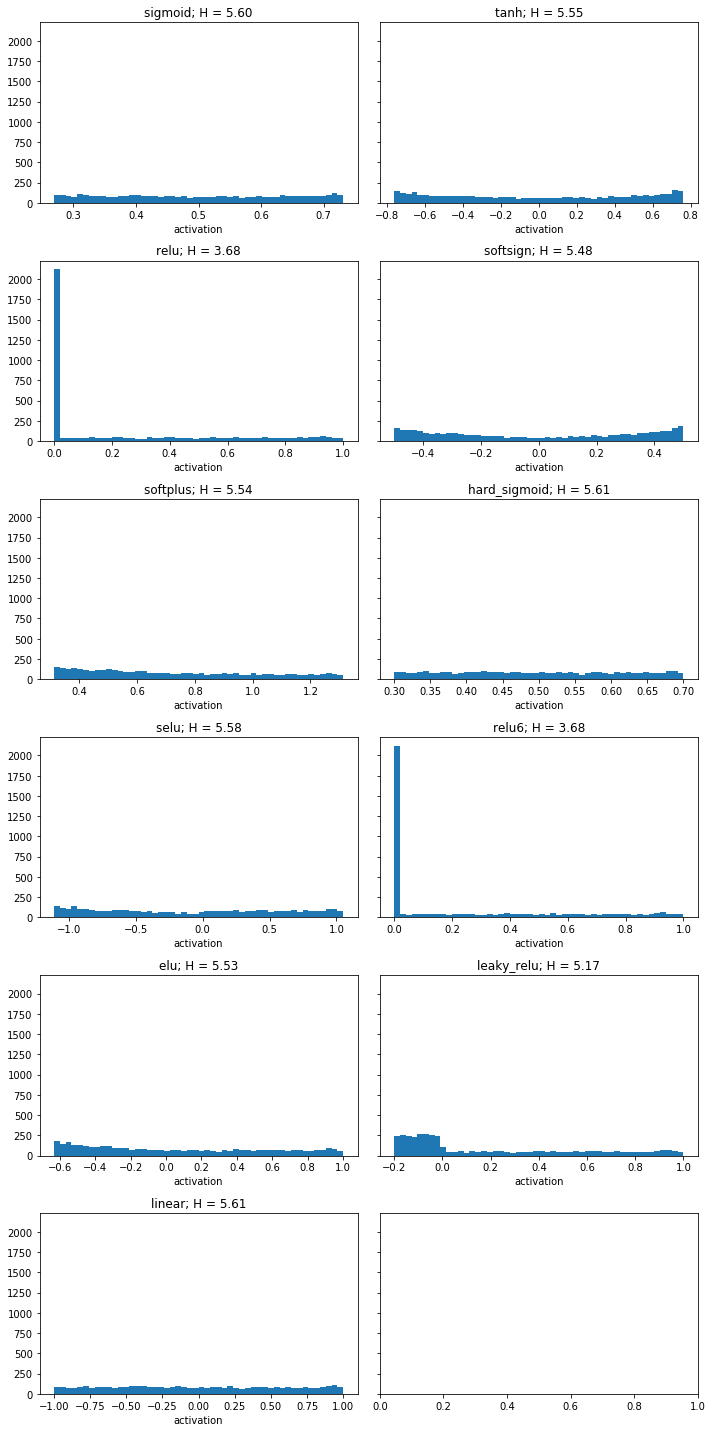

In [5]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 20), sharey=True)
ax = ax.flat
entropies = {}
for ax_idx, (activation_function, Y) in enumerate(outputs.items()):
    min_acitivity = Y.min()
    max_acitivity = Y.max()
   
    bins = np.linspace(min_acitivity, max_acitivity, 50)
    digitized, _ = np.histogram(Y, bins=bins)

    entropies[activation_function] = stats.entropy(digitized, base=2)
    
    ax[ax_idx].hist(Y,  bins=50)
    ax[ax_idx].set(title=f'{activation_function}; H = {entropies[activation_function]:.2f}', xlabel='activation')
plt.tight_layout()
plt.show()

To display the effect of the activation function on the entropy of the distribution in a more compact manner, we sort the remaining entropies by magnitude and plot against the respective activation function names.

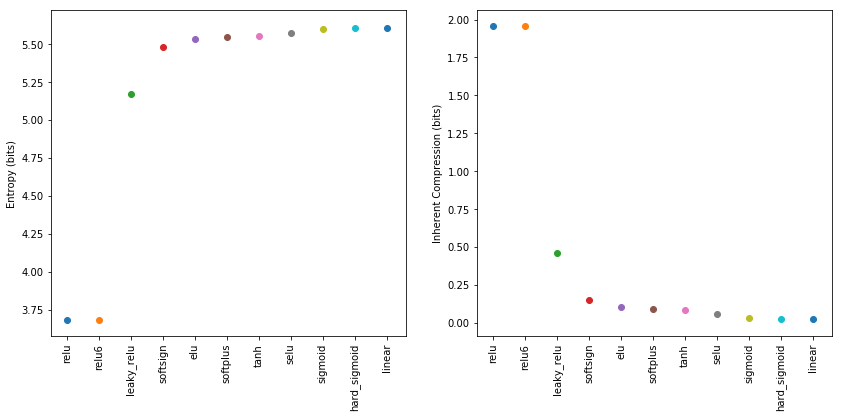

In [6]:
sorted_entropies = sorted(entropies.items(), key=lambda kv: kv[1])
xlabels = list(zip(*sorted_entropies))[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
for index, (activation_function, H) in enumerate(sorted_entropies):
    ax[0].scatter(index, H)
    ax[1].scatter(index, entropy_uniform_dist-H)

ax[0].set_xticks(range(len(entropies.keys())))
ax[0].set_xticklabels(xlabels, rotation=90)
ax[0].set_ylabel('Entropy (bits)')

ax[1].set_xticks(range(len(entropies.keys())))
ax[1].set_xticklabels(xlabels, rotation=90)
ax[1].set_ylabel('Inherent Compression (bits)')

plt.show()

We can conclude from this simple experiment, that the `relu` nonlinearity has a strong bias on the mutual information of the representation with the input, as it imposes a lot of structure onto the activations. We hypothesize that `relu` activated hidden layers should therefore carry less information about the input as compared to a `tanh` activated layers. This effect is immediate from the very beginning of the training. Moreover, within the terminology of the information bottleneck, this boils down to "immediate compression". The exact magnitude of this effect within the experiments we ran has still to be estimated. 

In the following we provide a toy example estimating the effect that gradually imposing structure on the distribution has on the entropy. We relate these examplary quantities to the effects of the activation function alone.

In [7]:
def _copy_neighbour(to_transform, iterations):
    """Sets every second value of a vector to the value of the preceding entry"""
    to_transform = np.copy(to_transform)
    to_transform_mass = np.sum(to_transform)

    #shuffle and replace all nonzero values to simulate more compact representation
    nonzeros = to_transform[to_transform != 0]
    zeros = np.zeros((to_transform.shape[0] - nonzeros.shape[0]))

    for iteration in range(iterations):
        nonzeros[1::2] = nonzeros[0:-1:2]
        np.random.shuffle(nonzeros)

    transformed = np.concatenate((nonzeros, zeros))
    return transformed

By repeatedly setting the value of every second data sample to its preceding neighbour, we "simplify" the representation in the information theoretic sense. After 200 iterations of this transformation, we arrive at a distributions which looks qualitatively similar to those observed after restricting the norm of the weight vector. (See notebook 7.weight_renormalization.ipynb for experiment details)

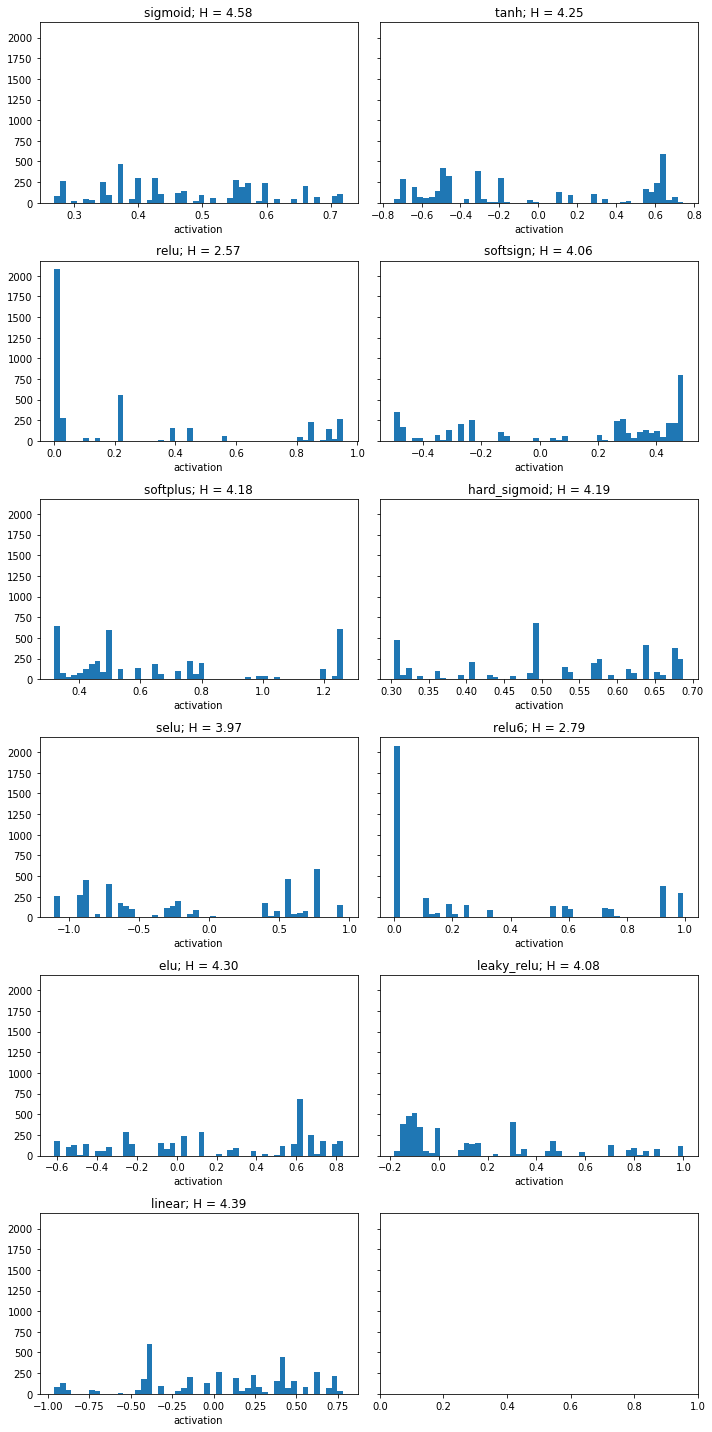

In [8]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 20), sharey=True)
ax = ax.flat
entropies_transformed = {}
for ax_idx, (activation_function, activities) in enumerate(outputs.items()):
    min_activity = activities.min()
    max_activity = activities.max()
   
    bins = np.linspace(min_activity, max_activity, 50)
    transformed_activities = _copy_neighbour(activities, 200) 
    digitized, _ = np.histogram(transformed_activities, bins=bins)


    entropies_transformed[activation_function] = stats.entropy(digitized, base=2)
    
    ax[ax_idx].hist(transformed_activities,  bins=50)
    ax[ax_idx].set(title=f'{activation_function}; H = {entropies_transformed[activation_function]:.2f}', xlabel='activation')
plt.tight_layout()
plt.show()

The plot below shows the further reduction in entropy by simplifying the representation.

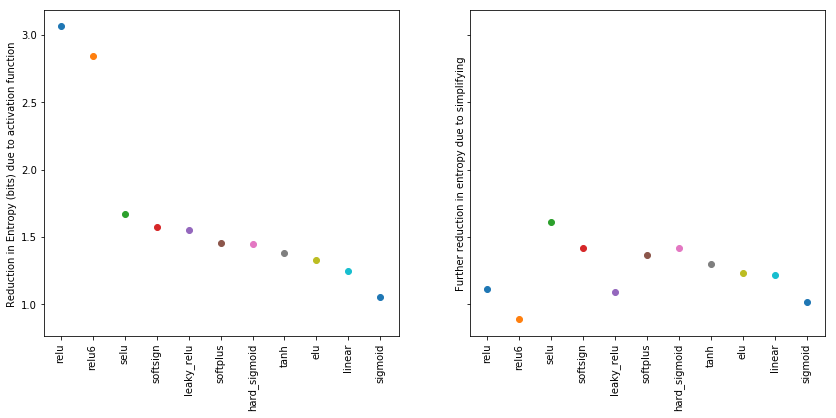

In [9]:
sorted_entropies = sorted(entropies_transformed.items(), key=lambda kv: kv[1])
xlabels = list(zip(*sorted_entropies))[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
for index, (activation_function, H) in enumerate(sorted_entropies):
    ax[0].scatter(index, entropy_uniform_dist-H)
    ax[1].scatter(index, entropies[activation_function]-H)

ax[0].set_xticks(range(len(entropies.keys())))
ax[0].set_xticklabels(xlabels, rotation=90)
ax[0].set_ylabel('Reduction in Entropy (bits) due to activation function')

ax[1].set_xticks(range(len(entropies.keys())))
ax[1].set_xticklabels(xlabels, rotation=90)
ax[1].set_ylabel('Further reduction in entropy due to simplifying')

plt.show()

We observe that the effect of imposing structure on the non-zero activations reduced the entropy further, but not even matching the amount of redution that was obtained by the relu activation alone. 

We therefore conclude that the bias of the relu activation function towards the mutual information with the input is strong, especially as the its size is not even matched by artifically imposed structure (for example by restricted weight norm) on the nonzero activations. We furthermore hypothesize that the relu compresses in the sense of the information botteneck framework, but does this immediately and not in a distinct phase of the training process. A more qunatitative approach testing this hypothesis is subject of another notebook. 